# Determine appropriate parameter range
<hr style="border:2px solid gray"> </hr>
This notebook is for determining parameter range that achieves equilibrium of malaria prevalence among the target population.

In [1]:
#import packages
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import r2_score
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Dense, Input, Dropout, concatenate
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, reciprocal
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import seaborn as sns
from pprint import pprint
import pandas as pd

In [2]:
print(keras.__version__)

2.9.0


In [8]:
def check_accuracy(x,y):
    """
        Check errors between predicted values and known result values.
        x: target value
        y: predicted value
    """
    rmse = sum(np.sqrt((x - y)**2) / len(x))
    actual_success = 0
    true_positives = 0
    false_negatives = 0
    false_positives = 0
    for i in range(len(x)):
        if x[i] >= 0.5:
            actual_success += 1
        if y[i] >= 0.5 and x[i] >= 0.5:
            true_positives += 1
        if y[i] < 0.5 and x[i] >= 0.5:
            false_negatives += 1
        if y[i] >= 0.5 and x[i] < 0.5:
            false_positives += 1
    precision = 0
    recall = 0
    if true_positives + false_positives:
        precision = true_positives / (true_positives + false_positives)
    if actual_success:
        recall = true_positives / actual_success
    
    return rmse, actual_success, true_positives, false_negatives, false_positives, precision, recall

## 0. Data processing

In [3]:
#load data
df = pd.read_csv("gen1000.csv")
df.columns


Index(['malaria_eliminated', 'malaria_prevalence', 'num_fertile_females',
       'adult_total_numbers', ' adult_female',
       '              healthy_mosquito', ' carrier_mosquito',
       'carrier_mosquito2', 'patient_mosquito', '              healthy_human',
       'carrier_human', 'patient_human', 'resistant_human',
       '              simulation_end', '              malaria_takein_rate',
       'malaria_sensitive', '              distance', 'remate_chance',
       'want_to_bite_rate', 'animal_bite_rate',
       '              low_density_growth_rate', 'seasonal_amplitude',
       'cureweek', 'immunity', '              density_num_adult_female',
       'human_density', 'sim_bound'],
      dtype='object')

In [4]:
df.columns = [col.replace(' ', '') for col in df.columns]
df['ID'] = df.groupby(['malaria_takein_rate','malaria_sensitive','distance','remate_chance','want_to_bite_rate','animal_bite_rate','low_density_growth_rate','seasonal_amplitude','cureweek','immunity']).ngroup()
print(df['ID'].describe())

count    44423.000000
mean      2226.564302
std       1286.032701
min          0.000000
25%       1113.000000
50%       2226.000000
75%       3341.000000
max       4453.000000
Name: ID, dtype: float64


In [5]:
selected_rows = df[df['simulation_end'] != 120]
print(selected_rows)

       malaria_eliminated  malaria_prevalence  num_fertile_females  \
56                      0            0.697694                70218   
60                      0            0.729008                70687   
61                      0            0.730563                70752   
62                      0            0.742812                66403   
63                      0            0.734317                30467   
...                   ...                 ...                  ...   
44378                   0            0.719293                50487   
44389                   0            0.720028                46981   
44401                   0            0.692925                62085   
44403                   0            0.694692                60518   
44406                   0            0.698362                59611   

       adult_total_numbers  adult_female  healthy_mosquito  carrier_mosquito  \
56                  120110         70218             59597                 0   

In [6]:
#Make new dataset that takes the average of 20 simulations of same parameter sets.
df_ave = pd.DataFrame(columns=df.columns, index=range(4454))


In [7]:
for i in range(0, df_ave.shape[0]):
    temp = df[df['ID'] == i]
    line = temp.mean(axis=0)
    #Adjust each variable based on characteristics
    #line['composite_se'] = temp['composite'].std()
    #line['duration_of_chasing'] = np.mean(temp.loc[temp['duration_of_chasing'] != 10000, 'duration_of_chasing'])
    #line['avg_female_fertile'] = np.mean(temp.loc[temp['avg_female_fertile'] != 1000000, 'avg_female_fertile'])
    line = line.fillna(0)
    df_ave.loc[i,:] = line

print(df_ave)

     malaria_eliminated malaria_prevalence num_fertile_females  \
0                   0.0           0.679346             46386.4   
1                   0.0           0.031483             43455.4   
2                   0.0           0.464629             40029.0   
3                   0.0           0.539701             49493.1   
4                   0.0           0.017449             42415.5   
...                 ...                ...                 ...   
4449                0.0           0.611253             42360.5   
4450                0.0           0.708227             46909.0   
4451                0.0           0.706213             40519.0   
4452                0.0              0.848             40735.1   
4453                0.0           0.686138             45899.7   

     adult_total_numbers adult_female healthy_mosquito carrier_mosquito  \
0                79868.4      46386.4          44072.2              0.0   
1                75003.8      43455.4          43426.0   

In [8]:

#normalize data
abs_scaler = MaxAbsScaler()

# calculate the maximum absolute value for scaling the data using the fit method
abs_scaler.fit(df_ave)
# the maximum absolute values calculated by the fit method
abs_scaler.max_abs_
# transform the data using the parameters calculated by the fit method (the maximum absolute values)
scaled_data = abs_scaler.transform(df_ave)
# store the results in a data frame
df_scaled = pd.DataFrame(scaled_data, columns=df.columns)
df_scaled

,malaria_eliminated,malaria_prevalence,num_fertile_females,adult_total_numbers,adult_female,healthy_mosquito,carrier_mosquito,carrier_mosquito2,patient_mosquito,healthy_human,...,want_to_bite_rate,animal_bite_rate,low_density_growth_rate,seasonal_amplitude,cureweek,immunity,density_num_adult_female,human_density,sim_bound,ID
0,0.0,0.770758,0.700720,0.701682,0.700720,0.706745,0.0,0.152306,0.139616,0.027604,...,0.959,0.578,0.833333,0.250,0.900000,0.80,1.0,1.0,1.0,0.000000
1,0.0,0.035720,0.656444,0.658944,0.656444,0.696383,0.0,0.001945,0.001771,0.958833,...,0.376,0.964,0.333333,0.250,0.933333,0.90,1.0,1.0,1.0,0.000225
2,0.0,0.527149,0.604684,0.615786,0.604684,0.629100,0.0,0.052503,0.048206,0.271792,...,0.692,0.734,0.388889,0.750,0.866667,0.75,1.0,1.0,1.0,0.000449
3,0.0,0.612323,0.747650,0.756732,0.747650,0.767166,0.0,0.111293,0.098925,0.393063,...,0.891,0.856,0.500000,0.875,0.500000,0.10,1.0,1.0,1.0,0.000674
4,0.0,0.019797,0.640735,0.642932,0.640735,0.679968,0.0,0.000808,0.000808,0.986979,...,0.481,0.230,0.500000,0.250,0.333333,0.20,1.0,1.0,1.0,0.000898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,0.0,0.693502,0.639904,0.647655,0.639904,0.581507,0.0,0.408379,0.365623,0.166208,...,0.725,0.762,0.388889,0.625,0.433333,0.25,1.0,1.0,1.0,0.999102
4450,0.0,0.803525,0.708614,0.712246,0.708614,0.605525,0.0,0.579625,0.559213,0.024604,...,0.739,0.901,0.944444,0.375,0.933333,0.70,1.0,1.0,1.0,0.999326
4451,0.0,0.801240,0.612086,0.622424,0.612086,0.566118,0.0,0.348578,0.312987,0.074479,...,0.615,0.960,1.000000,0.750,1.000000,0.75,1.0,1.0,1.0,0.999551
4452,0.0,0.962106,0.615351,0.626145,0.615351,0.545214,0.0,0.455831,0.402332,0.117250,...,0.573,0.315,0.777778,0.875,0.900000,0.00,1.0,1.0,1.0,0.999775


In [9]:
df.columns

Index(['malaria_eliminated', 'malaria_prevalence', 'num_fertile_females',
       'adult_total_numbers', 'adult_female', 'healthy_mosquito',
       'carrier_mosquito', 'carrier_mosquito2', 'patient_mosquito',
       'healthy_human', 'carrier_human', 'patient_human', 'resistant_human',
       'simulation_end', 'malaria_takein_rate', 'malaria_sensitive',
       'distance', 'remate_chance', 'want_to_bite_rate', 'animal_bite_rate',
       'low_density_growth_rate', 'seasonal_amplitude', 'cureweek', 'immunity',
       'density_num_adult_female', 'human_density', 'sim_bound', 'ID'],
      dtype='object')

In [13]:
from sklearn.model_selection import train_test_split

Train, Test = train_test_split(df_scaled, test_size=0.5, random_state=42)
X_train = Train.loc[:,['malaria_takein_rate','malaria_sensitive','distance','remate_chance','want_to_bite_rate','animal_bite_rate','low_density_growth_rate','seasonal_amplitude','cureweek','immunity']]
y_train = Train.loc[:,['malaria_eliminated', 'malaria_prevalence']]
X_test = Test.loc[:,['malaria_takein_rate','malaria_sensitive','distance','remate_chance','want_to_bite_rate','animal_bite_rate','low_density_growth_rate','seasonal_amplitude','cureweek','immunity']]
y_test = Test.loc[:,['malaria_eliminated', 'malaria_prevalence']]

## 1. Implementing Deep learning

In [14]:
# Define the input layer
inputs = Input(shape=(10,))

# Define the hidden layers
x = Dense(128, activation='relu')(inputs)
x = Dense(32, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(32, activation='relu')(x)

eliminate = Dense(1, activation='linear', name="eliminate")(x)
prevalence = Dense(1, activation='linear', name = "prevalence")(x)

# Define the model
model = Model(inputs=inputs, outputs=[eliminate, prevalence])

# Compile the model
model.compile(optimizer = 'adam', loss='mse')

# Train the model
model.fit(X_train, [y_train["malaria_eliminated"],y_train["malaria_prevalence"]], epochs=100, batch_size=32, validation_freq=0.1)

Epoch 1/100


2023-06-02 16:32:45.356160: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1/70 [..............................] - ETA: 32s - loss: 0.3058 - eliminate_loss: 2.4626e-04 - prevalence_loss: 0.3055

2023-06-02 16:32:45.661019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 1s 8ms/step - loss: 0.1215 - eliminate_loss: 0.0402 - prevalence_loss: 0.0813
Epoch 2/100
70/70 [==============================] - 1s 7ms/step - loss: 0.0291 - eliminate_loss: 0.0101 - prevalence_loss: 0.0190
Epoch 3/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0221 - eliminate_loss: 0.0091 - prevalence_loss: 0.0130
Epoch 4/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0171 - eliminate_loss: 0.0075 - prevalence_loss: 0.0096
Epoch 5/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0126 - eliminate_loss: 0.0058 - prevalence_loss: 0.0069
Epoch 6/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0108 - eliminate_loss: 0.0046 - prevalence_loss: 0.0062
Epoch 7/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0090 - eliminate_loss: 0.0036 - prevalence_loss: 0.0054
Epoch 8/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0075 - eliminate_los

In [15]:
model.evaluate(X_test,y_test)
#plot_model(model,show_layer_activations=True, show_dtype=True, show_layer_names=True, show_shapes=True)


26/70 [==========>...................] - ETA: 0s - loss: 0.3901 - eliminate_loss: 0.1921 - prevalence_loss: 0.1980

2023-06-02 16:33:37.688412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 0s 4ms/step - loss: 0.3986 - eliminate_loss: 0.1967 - prevalence_loss: 0.2019


[0.3986316919326782, 0.19668427109718323, 0.20194746553897858]

In [12]:
#save models

#model.save("230511_NN_ParamRange_2")
model = keras.models.load_model('230511_NN_ParamRange_2')
#plot_model(model, to_file='230511_NN_ParamRange.png', show_layer_activations=True, show_dtype=True, show_layer_names=True, show_shapes=True)

FileNotFoundError: Op type not registered 'DisableCopyOnRead' in binary running on Yuans-iMac.local. Make sure the Op and Kernel are registered in the binary running in this process. Note that if you are loading a saved graph which used ops from tf.contrib, accessing (e.g.) `tf.contrib.resampler` should be done before importing the graph, as contrib ops are lazily registered when the module is first accessed.
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [16]:
predict_model = model.predict(X_test)
#predict_model = pd.DataFrame(np.concatenate(predict_model, axis=1), columns=["suppressed","composite", "chased","longterm","duration_of_chasing","avg_female_fertile"])
#df = pd.DataFrame(data=np.concatenate(data_list, axis=1), columns=['col1', 'col2'])
X_test

70/70 [==============================] - 0s 2ms/step


2023-06-02 16:33:43.074435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,malaria_takein_rate,malaria_sensitive,distance,remate_chance,want_to_bite_rate,animal_bite_rate,low_density_growth_rate,seasonal_amplitude,cureweek,immunity
2855,0.703333,0.622914,0.338182,0.978,0.691,0.243,0.333333,0.125,0.633333,0.40
693,0.313333,0.727475,0.549091,0.961,0.474,0.328,0.833333,0.500,0.666667,0.55
1429,0.446667,0.697442,0.548485,0.397,0.276,0.428,0.888889,0.625,0.433333,0.50
1200,0.406296,0.599555,0.370303,0.757,0.336,0.784,0.388889,0.625,0.566667,0.40
3948,0.904815,0.635150,0.789697,0.694,0.772,0.181,0.277778,0.625,0.400000,0.70
...,...,...,...,...,...,...,...,...,...,...
1494,0.458519,0.779755,0.660000,0.773,0.625,0.434,0.444444,0.000,0.866667,0.65
1232,0.411481,0.822024,0.678182,0.705,0.526,0.783,1.000000,0.750,0.766667,0.35
2293,0.603333,0.512792,0.338182,0.180,0.912,0.375,1.000000,0.250,0.366667,0.45
1153,0.398519,0.499444,0.472727,0.439,0.989,0.242,0.888889,0.750,0.500000,0.90


In [17]:
#supp_accuracy = check_accuracy(y_test["malaria_eliminated"], predict_model[0].flatten())
#composite_accuracy = check_accuracy(y_test["malaria_prevalence"], predict_model[1].flatten())

supp_r2 = r2_score(y_test["malaria_eliminated"], predict_model[0].flatten())
comp_r2 = r2_score(y_test["malaria_prevalence"], predict_model[1].flatten())


print(supp_r2)
print(comp_r2)

0.8700240312431806
0.9825688142371096


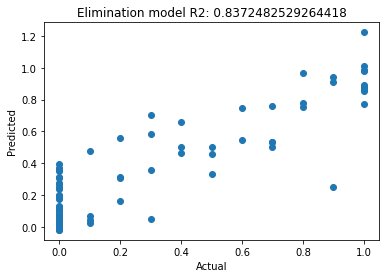

In [22]:
#Show scatter plot of Actual value vs Predicted value for Regressor model
fig, ax = plt.subplots()
#ax.scatter(y_test["suppressed"], predict_model[:,0])
ax.scatter(y_test["malaria_eliminated"], predict_model[0].flatten())
#ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#ax.set_title('Suppression model R2: ' + str(r2_score(y_test["suppressed"], predict_model[:,0])))
ax.set_title('Elimination model R2: ' + str(r2_score(y_test["malaria_eliminated"], predict_model[0].flatten())))
plt.show()

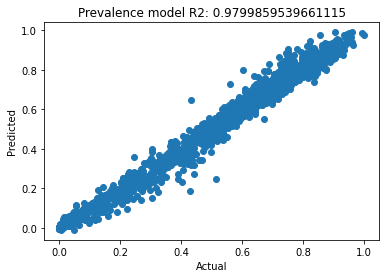

In [23]:
#Show scatter plot of Actual value vs Predicted value for Regressor model
fig, ax = plt.subplots()
#ax.scatter(y_test["composite"], predict_model[:,1])
ax.scatter(y_test["malaria_prevalence"], predict_model[1].flatten())
#ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#ax.set_title('Composite model R2: ' + str(r2_score(y_test["composite"], predict_model[:,1])))
ax.set_title('Prevalence model R2: ' + str(r2_score(y_test["malaria_prevalence"], predict_model[1].flatten())))
plt.show()

Now I am going to predict the parameter values that reaches to equilibrium

In [18]:
##This is for testing data
input_ranges = {'malaria_takein_rate': [0.05, 0.27], 
                'malaria_sensitive': [0.2, 0.9], 
                'distance': [0.08,0.165], #training: [0.033,0.165]
                'remate_chance': [0,1],
                'want_to_bite_rate': [0.25,1],
                'animal_bite_rate': [0,1],
                'low_density_growth_rate': [2,18],
                'seasonal_amplitude': [0,0.8],
                'cureweek': [10,30],
                'immunity': [0,20]}

In [19]:
num_inputs = 100000  # the number of input values to generate
inputs = {}
for feature in input_ranges:
    inputs[feature] = np.random.uniform(input_ranges[feature][0], input_ranges[feature][1], num_inputs)


In [20]:
inputs = pd.DataFrame(inputs)

#normalize data
abs_scaler = MaxAbsScaler()

# calculate the maximum absolute value for scaling the data using the fit method
abs_scaler.fit(inputs)
# the maximum absolute values calculated by the fit method
abs_scaler.max_abs_
# transform the data using the parameters calculated by the fit method (the maximum absolute values)
scaled_data = abs_scaler.transform(inputs)
# store the results in a data frame
inputs_scaled = pd.DataFrame(scaled_data, columns=inputs.columns)
inputs_scaled

,malaria_takein_rate,malaria_sensitive,distance,remate_chance,want_to_bite_rate,animal_bite_rate,low_density_growth_rate,seasonal_amplitude,cureweek,immunity
0,0.566730,0.653774,0.609427,0.821953,0.766059,0.907425,0.380801,0.365239,0.538663,0.197708
1,0.767966,0.313068,0.556101,0.596043,0.870780,0.144551,0.555448,0.500115,0.740156,0.755369
2,0.534931,0.303548,0.645882,0.744809,0.842377,0.094958,0.280118,0.949861,0.911739,0.154992
3,0.551553,0.935571,0.932459,0.636578,0.316890,0.461757,0.474056,0.564907,0.632588,0.788608
4,0.562337,0.709821,0.721394,0.374380,0.864943,0.722843,0.118580,0.228789,0.768787,0.125596
...,...,...,...,...,...,...,...,...,...,...
99995,0.549762,0.270629,0.613651,0.061312,0.576391,0.988569,0.131308,0.734982,0.593993,0.831102
99996,0.604122,0.577765,0.807505,0.067603,0.914322,0.943252,0.734555,0.674358,0.558944,0.311420
99997,0.408920,0.933060,0.988112,0.202686,0.807654,0.007189,0.719954,0.067835,0.339444,0.285954
99998,0.681496,0.759957,0.929237,0.162763,0.644597,0.676324,0.160238,0.126276,0.723629,0.752250


In [32]:
#preds = model.predict([inputs['malaria_takein_rate'], inputs['malaria_sensitive'],inputs['distance'], inputs['remate_chance'],inputs['want_to_bite_rate'],inputs['animal_bite_rate'],inputs['low_density_growth_rate'],inputs['seasonal_amplitude'],inputs['cureweek'],inputs['immunity']])[1].flatten()
preds = model.predict(inputs_scaled)[1].flatten()
preds

3125/3125 [==============================] - 5s 2ms/step


array([0.78222597, 0.732348  , 0.8149686 , ..., 0.6967635 , 0.762871  ,
       0.96085936], dtype=float32)

In [34]:
target_inputs = inputs_scaled[(preds >= 0.3) & (preds <= 0.5)]
target_inputs_orig = abs_scaler.inverse_transform(target_inputs)
target_inputs


,malaria_takein_rate,malaria_sensitive,distance,remate_chance,want_to_bite_rate,animal_bite_rate,low_density_growth_rate,seasonal_amplitude,cureweek,immunity
3,0.551553,0.935571,0.932459,0.636578,0.316890,0.461757,0.474056,0.564907,0.632588,0.788608
23,0.635855,0.348873,0.600767,0.457737,0.527034,0.749332,0.624940,0.159674,0.555503,0.900119
29,0.711262,0.700725,0.978331,0.389222,0.280968,0.466974,0.921559,0.581309,0.507379,0.532378
36,0.187822,0.908548,0.729924,0.265307,0.455057,0.674062,0.294983,0.928003,0.734469,0.389092
38,0.899806,0.859597,0.653277,0.486622,0.298850,0.845740,0.560786,0.344850,0.545884,0.909322
...,...,...,...,...,...,...,...,...,...,...
99971,0.351989,0.261118,0.541288,0.275326,0.574798,0.634675,0.445916,0.494402,0.739854,0.683536
99984,0.567372,0.358880,0.612884,0.596871,0.816404,0.538881,0.199266,0.805380,0.348769,0.717332
99988,0.708679,0.705047,0.732881,0.609412,0.286138,0.107188,0.539653,0.569741,0.465777,0.205177
99992,0.467414,0.277196,0.990421,0.994366,0.477833,0.524416,0.259601,0.692775,0.764671,0.022072


In [35]:
#confirm what will happen if want_to_bite_rate was changed
target_inputs_test = target_inputs
target_inputs_test["want_to_bite_rate"] = 0.3
preds2 = model.predict(target_inputs_test)[1].flatten()
target_inputs_test[(preds2 >= 0.3) & (preds2 <= 0.5)]

 80/399 [=====>........................] - ETA: 0s

/var/folders/vg/l5dng3c524zb68tvvplc7zrw0000gn/T/ipykernel_24118/2050044074.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_inputs_test["want_to_bite_rate"] = 0.3


399/399 [==============================] - 1s 2ms/step


,malaria_takein_rate,malaria_sensitive,distance,remate_chance,want_to_bite_rate,animal_bite_rate,low_density_growth_rate,seasonal_amplitude,cureweek,immunity
3,0.551553,0.935571,0.932459,0.636578,0.3,0.461757,0.474056,0.564907,0.632588,0.788608
29,0.711262,0.700725,0.978331,0.389222,0.3,0.466974,0.921559,0.581309,0.507379,0.532378
38,0.899806,0.859597,0.653277,0.486622,0.3,0.845740,0.560786,0.344850,0.545884,0.909322
137,0.970200,0.352488,0.746043,0.797983,0.3,0.047656,0.229917,0.791712,0.761211,0.808007
216,0.948067,0.418312,0.862360,0.025132,0.3,0.937813,0.116185,0.604773,0.627980,0.319458
...,...,...,...,...,...,...,...,...,...,...
99741,0.862737,0.384502,0.541824,0.173197,0.3,0.277705,0.508551,0.355033,0.861660,0.384486
99830,0.661956,0.572246,0.761000,0.877064,0.3,0.101233,0.614929,0.964605,0.834769,0.767038
99840,0.984563,0.270417,0.945502,0.162641,0.3,0.790034,0.992543,0.088552,0.916227,0.661368
99935,0.771095,0.668073,0.968830,0.990129,0.3,0.663088,0.248087,0.414476,0.474135,0.080493


In [8]:
pd.DataFrame(target_inputs_orig,columns=inputs.columns).describe()

,malaria_takein_rate,malaria_sensitive,distance,remate_chance,want_to_bite_rate,animal_bite_rate,low_density_growth_rate,seasonal_amplitude,cureweek,immunity
count,14369.000000,14369.000000,14369.000000,14369.000000,14369.000000,14369.000000,14369.000000,14369.000000,14369.000000,14369.000000
mean,0.140839,0.493325,0.121985,0.502512,0.490823,0.501527,10.000425,0.410582,17.257628,11.491244
std,0.062858,0.196470,0.024554,0.288034,0.176016,0.289887,4.629510,0.231047,5.494617,5.620845
min,0.050010,0.200034,0.080001,0.000019,0.250025,0.000006,2.003763,0.000052,10.000178,0.003180
25%,0.085665,0.322499,0.100547,0.253742,0.350309,0.250035,5.968881,0.212216,12.557877,6.945244
50%,0.130580,0.464889,0.121709,0.501689,0.450260,0.504428,10.005051,0.417098,15.965373,12.153284
75%,0.191546,0.651737,0.143314,0.749854,0.597641,0.750244,14.035306,0.611291,21.239683,16.369925
max,0.269976,0.899975,0.164985,0.999955,0.999825,0.999888,17.999693,0.799984,29.995616,19.999748


Make a paramset table for Gene drive related parameters.

In [9]:
#drive related#
#for test data
input_ranges = {'DDfitness': [0.85, 1], #training: [0.8, 1]
                'SOMATIC_FITNESS_MULTIPLIER_F': [0.6,1], #training: [0.5,1]
                'grc_beta': [0,0.999],
                'drive_conversion': [0.9,1], #training: [0.8,1]
                'erc_f': [0,0.4], #training: [0,0.8]
                'r1': [0,0.001]}

num_inputs = 14000  # the number of input values to generate
inputs = {}
for feature in input_ranges:
    inputs[feature] = np.random.uniform(input_ranges[feature][0], input_ranges[feature][1], num_inputs)



Make a paramset.txt based on these inputs, and add gene drive related values in the parameter as well.

In [10]:
inputs


{'DDfitness': array([0.88968993, 0.97073275, 0.97330364, ..., 0.96230764, 0.99688045,
        0.85240278]),
 'SOMATIC_FITNESS_MULTIPLIER_F': array([0.69467864, 0.92769067, 0.76190117, ..., 0.95833353, 0.65518285,
        0.92441304]),
 'grc_beta': array([0.09602466, 0.37112701, 0.95017865, ..., 0.42236273, 0.3035543 ,
        0.2498527 ]),
 'drive_conversion': array([0.90676992, 0.94767897, 0.99891009, ..., 0.95654786, 0.97720573,
        0.94294665]),
 'erc_f': array([0.27768765, 0.27147565, 0.21381585, ..., 0.08547842, 0.18166868,
        0.07429709]),
 'r1': array([7.61022067e-04, 9.13615541e-05, 6.44352147e-04, ...,
        2.00034803e-05, 1.28071808e-04, 5.50941277e-04])}

In [11]:
target_inputs_orig

array([[1.17371632e-01, 2.05498388e-01, 8.19007002e-02, ...,
        1.15251434e-02, 1.16951311e+01, 7.41658761e+00],
       [9.29899716e-02, 5.54842991e-01, 1.50831557e-01, ...,
        7.90175175e-01, 1.63030097e+01, 6.96486192e-01],
       [9.03863348e-02, 7.21243029e-01, 9.92476727e-02, ...,
        4.85454462e-01, 1.13601210e+01, 1.11839143e+01],
       ...,
       [1.39592591e-01, 2.70107315e-01, 1.09336847e-01, ...,
        3.14091799e-01, 1.69121656e+01, 1.30125191e+01],
       [1.51373242e-01, 6.92950269e-01, 1.02983519e-01, ...,
        3.00534004e-01, 1.08209111e+01, 1.88236272e+01],
       [9.27229655e-02, 4.78562975e-01, 1.32083054e-01, ...,
        5.52910228e-01, 1.51311674e+01, 9.70183043e+00]])

In [12]:
with open('param_testdata.txt', 'w') as f:
        for i in range(12000):
                print(f"python 230407_mosquito_malaria_slim_driver.py -malaria_takein_rate {target_inputs_orig[i,0]:.4f} -malaria_sensitive {target_inputs_orig[i,1]:.3f} -distance {target_inputs_orig[i,2]:.4f} -ldgr {target_inputs_orig[i,6]:.0f} -remate_chance {target_inputs_orig[i,3]:.3f} -want_to_bite_rate {target_inputs_orig[i,4]:.3f} -animal_bite_rate {target_inputs_orig[i,5]:.3f} -less_seasonal_amplitude {target_inputs_orig[i,7]:.1f} -cure_week {target_inputs_orig[i,8]:.0f} -immunity {target_inputs_orig[i,9]:.0f} -dd {inputs['DDfitness'][i]:.3f} -sfm_f {inputs['SOMATIC_FITNESS_MULTIPLIER_F'][i]:.3f} -grc_beta {inputs['grc_beta'][i]:.4f} -dc {inputs['drive_conversion'][i]:.3f} -erc_f {inputs['erc_f'][i]:.4f} -r1 {inputs['r1'][i]:.6f}", file=f)